# OSCR preconditioned high-frequency scattering

### Background

*Please note that this notebook is adjusted for larger workstations. To run it on a small laptop adjust the wavenumber parameter ``k`` to a very small value (e.g. ``k = 5``).*

A typical application for BEM is the high-frequency scattering of an incoming wave $u^\text{inc}$ from a sound-hard obstacle $\Omega$.

Consider the exterior Helmholtz problem:

$$
\begin{align}
\Delta u^\text{+} + k^2u^\text{+} &= 0,\quad\text{in }\Omega^\text{+}\\
\frac{\partial u^\text{+}}{\partial\nu} &= -\frac{\partial u^\text{inc}}{\partial\nu},\quad\text{on }\Gamma\\
\lim_{|\mathbf{x}|\rightarrow+\infty}|\mathbf{x}|\left(\nabla u^\text{+}\cdot \frac{\mathbf{x}}{|\mathbf{x}|}-\mathrm{i}ku^\text{+}\right)&=0
\end{align}
$$

Here, $u^+$ is the scattered field, and hence the total field is $u = u^\text{+}+u^{inc}$. The scattered field $u^\text{+}$ can be
represented as
$$
u^{+} = \mathcal{K}\phi,
$$
where $\mathcal{K}$ is the <a href='https://bempp.com/2017/07/11/available_operators/'>double layer potential operator</a> defined by
$$
\left[\mathcal{K}\phi\right](\mathbf{x}) = \int_{\Gamma}g(\mathbf{x},\mathbf{y})\phi(\mathbf{y})\mathrm{d}\mathbf{y}
$$
with $g(\mathbf{x},\mathbf{y}) = \frac{\mathrm{e}^{\mathrm{i}k|\mathbf{x}-\mathbf{y}|}}{4\pi|\mathbf{x}-\mathbf{y}|}$. Here, $\phi=\gamma_0u$ is the Dirichlet trace of the total field.

The Burton&ndash;Miller formulation to compute $\phi$ is given by
$$
\left(\tfrac{1}{2}\mathsf{Id}-\mathsf{K}+\eta\mathsf{W}\right)\phi = \gamma_0 u^\text{inc}+\eta \gamma_1u^\text{inc}
$$
for some $\eta\neq 0$. Here, $\mathsf{Id}$, $\mathsf{K}$ and $\mathsf{W}$ are the identity, double layer and hypersingular boundary operators.

A perfect choice for $\eta$ is the exterior Neumann-to-Dirichlet map $\mathsf{NtD}$ with the property
$$
\tfrac{1}{2}\mathsf{Id}-\mathsf{K}-\mathsf{NtD}\circ\mathsf{W} = \mathsf{Id}.
$$
However, this is a complicated non-local operator.  The idea of OSRC is to use the pseudodifferential operator approximation
$$
\mathsf{NtD}\approx \frac{1}{\mathrm{i}k}\left(1+\frac{\Delta_{\Gamma}}{(k+\mathrm{i}\epsilon)^2}\right)^{-\frac{1}{2}}
$$
for a regularization parameter $\epsilon>0$ and to localize the squareroot operator by a Pad&eacute; approximation. Details of this OSRC preconditioning are given in <a href='https://www.esaim-m2an.org/articles/m2an/abs/2007/01/m2an0606/m2an0606.html' target='new'>Antoine & Darbase (2007)</a>.

Bempp implements approximate Dirichlet-to-Neumann and Neumann-to-Dirichlet maps. This notebook demonstrates how to use these for high-frequency scattering computations.


### Implementation

In the following we implement an OSRC Burton&ndash;Miller formulation for high-frequency scattering. We start with the usual imports.

In [1]:
import bempp.api
import numpy as np

The following defines the wavenumber k and the Dirichlet and Neumann data of the incident plane wave.

In [2]:
k = 20

def dirichlet_fun(x, n, domain_index, result):
    result[0] = np.exp(1j * k * x[0])

def neumann_fun(x, n, domain_index, result):
    result[0] = 1j * k * n[0] * np.exp(1j * k * x[0])

For this example we will use an elongated ellipsoid. The element size is chosen to roughly correspond to 10 elements per wavelength. The function space consists of continuous, piecewise linear basis functions. The OSRC preconditioner only works for continuous function spaces as it assembles a Laplace&ndash;Beltrami operator.

In [3]:
h = 2*np.pi/(10 * k)
grid = bempp.api.shapes.ellipsoid(3, 1, 1, h=h)
space = bempp.api.function_space(grid, "P", 1)
print("The space has {0} dofs".format(space.global_dof_count))

The space has 2477 dofs


We can now form the Burton&ndash;Miller operator.

In [4]:
identity = bempp.api.operators.boundary.sparse.identity(
    space, space, space)
dlp = bempp.api.operators.boundary.helmholtz.double_layer(
    space, space, space, k)
hyp = bempp.api.operators.boundary.helmholtz.hypersingular(
    space, space, space, k, use_slp=True)
ntd = bempp.api.operators.boundary.helmholtz.osrc_ntd(space, k)

burton_miller = .5 * identity - dlp - ntd * hyp

In the above operator assembly we were allowed to directly multiply operators. Bempp automatically assembles the correct mass matrix transformations for this product to make sense. For the assembly of the hypersingular operator we used the parameter ``use_slp=True``. This will cause the hypersingular operatorto be assembled in terms of an underlying Helmholtz single layer operator. This approach takes more memory but the <a href='https://bempp.com/2017/07/12/2017/07/12/fast-assembly-via-hierarchical-matrices/'>H-matrix assembly</a> is significantly faster.

We next assemble the right-hand side.

In [5]:
dirichlet_grid_fun = bempp.api.GridFunction(space, fun=dirichlet_fun)
neumann_grid_fun = bempp.api.GridFunction(space, fun=neumann_fun)
rhs_fun = dirichlet_grid_fun - ntd * neumann_grid_fun

We can now solve the Burton&ndash;Miller formulation using GMRES. We use a strong form discretisation: this automatically performs mass matrix preconditioning.

In [11]:
total_field, info, it_count = bempp.api.linalg.gmres(
    burton_miller, rhs_fun, use_strong_form=True,
    return_iteration_count=True)

print("The linear system was solved in {0} iterations".format(it_count))

The linear system was solved in 6 iterations


We now want to plot the radar cross section in the $z=0$ plane. To compute it we use the far-field operators implemented in Bempp.

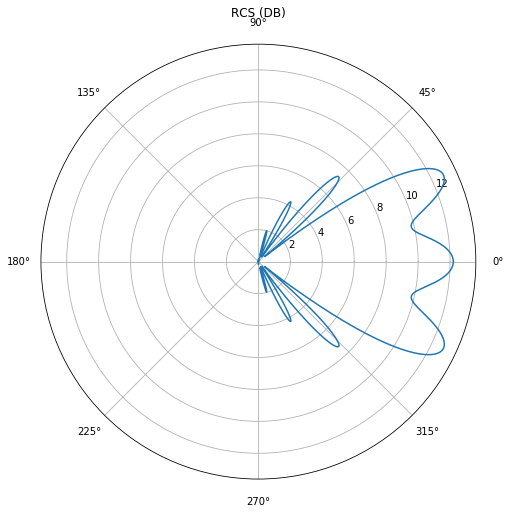

In [12]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import pylab
pylab.rcParams['figure.figsize'] = (8.0, 8.0)

theta = np.linspace(-np.pi/2, np.pi/2, 400)
points = np.array([np.cos(theta), np.sin(theta), np.zeros(len(theta))])

dlp_far_field = bempp.api.operators.far_field.helmholtz.double_layer(
    space, points, k)
far_field = dlp_far_field * total_field
max_incident = np.abs(dirichlet_grid_fun.coefficients).max()
radiation_pattern = (np.abs(far_field/max_incident)**2).ravel()
db_pattern = 10 * np.log10(4 * np.pi * radiation_pattern)

plt.polar(theta, db_pattern)
plt.title('RCS (DB)')